In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import io
import csv

path = "tabela1612-3.csv"

# Leitura tolerante (pula as 3 primeiras linhas de metadados)
df0 = pd.read_csv(path, sep=";", quotechar='"', skiprows=3, header=0, engine="python", on_bad_lines="skip")

print("Shape inicial:", df0.shape)
df0.head(5)


Shape inicial: (289, 546)


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Unidade da Federação,2007,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 536,Unnamed: 537,Unnamed: 538,Unnamed: 539,Unnamed: 540,Unnamed: 541,Unnamed: 542,Unnamed: 543,Unnamed: 544,2023
Unidade da Federação,Total,Abacaxi*,Alfafa fenada,Algodão herbáceo (em caroço),Alho,Amendoim (em casca),Arroz (em casca),Aveia (em grão),Batata-doce,Batata-inglesa,Cana-de-açúcar,Cana para forragem,Cebola,Centeio (em grão),Cevada (em grão),Ervilha (em grão),Fava (em grão),Feijão (em grão),Fumo (em folha),Girassol (em grão),Juta (fibra),Linho (semente),Malva (fibra),Mamona (baga),Mandioca,Melancia,Melão,Milho (em grão),Rami (fibra),Soja (em grão),Sorgo (em grão),Tomate,Trigo (em grão),Triticale (em grão),Total,Abacaxi*,Alfafa fenada,Algodão herbáceo (em caroço),Alho,Amendoim (em casca),Arroz (em casca),Aveia (em grão),...,Mandioca,Melancia,Melão,Milho (em grão),Rami (fibra),Soja (em grão),Sorgo (em grão),Tomate,Trigo (em grão),Triticale (em grão)
Rondônia,383553,565,...,-,-,152,72202,-,-,-,3047,...,-,-,-,-,-,62851,-,-,-,-,-,-,30509,852,-,123480,-,89520,-,375,-,-,408939,687,...,-,-,119,71031,-,...,17952,893,12,356552,-,589983,607,177,-,-
Acre,107877,251,...,-,-,65,22074,-,11,-,1022,...,-,-,-,-,-,14410,184,-,-,-,-,-,32232,463,-,37065,-,100,-,-,-,-,98425,313,...,-,-,118,18184,-,...,22025,1253,-,40831,-,12010,243,-,-,-
Amazonas,144985,6252,...,-,-,-,9764,-,326,-,6274,...,-,-,-,-,-,5313,222,-,4015,-,10180,-,79212,5816,63,16120,-,806,-,622,-,-,139022,2474,...,-,-,-,4901,-,...,66153,3387,24,3340,-,8237,-,4,-,-
Roraima,41908,201,...,-,-,-,19000,-,-,-,548,...,-,-,-,-,-,1000,-,-,-,-,-,-,6210,970,30,6500,-,7000,-,449,-,-,46133,201,...,-,-,-,22200,-,...,6264,1858,45,13774,-,128197,-,131,-,-


In [35]:
# Extrair a segunda linha como "produtos"
second_header = df0.iloc[0].astype(str).tolist()
first_header = [str(c) for c in df0.columns]

# Função para preencher anos ausentes no cabeçalho
def ffill_years(headers):
    years = []
    current = None
    for h in headers:
        match = re.search(r"\b(20\d{2})\b", h or "")
        if match:
            current = match.group(1)
        years.append(current)
    return years

years_ff = ffill_years(first_header)

# Criar nomes de colunas no formato "2019 - Soja (em grão)"
new_cols = ["local"]
for j in range(1, len(first_header)):
    year = years_ff[j] if years_ff[j] else "?"
    prod = second_header[j].strip()
    new_cols.append(f"{year} - {prod}")

# Aplicar novas colunas e remover a linha de cabeçalho duplicada
df_flat = df0.copy()
df_flat.columns = new_cols
df_flat = df_flat.iloc[1:].reset_index(drop=True)

print("Após renomear:", df_flat.shape)
df_flat.head(3)


Após renomear: (288, 546)


,local,2007 - Triticale (em grão),2007 - Total,2007 - Abacaxi*,2007 - Alfafa fenada,2007 - Algodão herbáceo (em caroço),2007 - Alho,2007 - Amendoim (em casca),2007 - Arroz (em casca),2007 - Aveia (em grão),...,2022 - Mandioca,2022 - Melancia,2022 - Melão,2022 - Milho (em grão),2022 - Rami (fibra),2022 - Soja (em grão),2022 - Sorgo (em grão),2022 - Tomate,2022 - Trigo (em grão),2023 - Triticale (em grão)
0,-,-,408939,687,...,-,-,119,71031,-,...,17952,893,12,356552,-,589983,607,177,-,-
1,-,-,98425,313,...,-,-,118,18184,-,...,22025,1253,-,40831,-,12010,243,-,-,-
2,-,-,139022,2474,...,-,-,-,4901,-,...,66153,3387,24,3340,-,8237,-,4,-,-


In [36]:
id_cols = ["local"]
val_cols = [c for c in df_flat.columns if c not in id_cols]

# Derreter colunas de ano-produto
long_df = df_flat.melt(id_vars=id_cols, value_vars=val_cols, var_name="ano_produto", value_name="valor_raw")

# Separar ano e produto
long_df[["ano", "produto"]] = long_df["ano_produto"].str.extract(r"(\b20\d{2}\b)\s*-\s*(.*)")
long_df = long_df.drop(columns=["ano_produto"])
long_df.head(5)


,local,valor_raw,ano,produto
0,-,-,2007,Triticale (em grão)
1,-,-,2007,Triticale (em grão)
2,-,-,2007,Triticale (em grão)
3,-,-,2007,Triticale (em grão)
4,-,-,2007,Triticale (em grão)


In [38]:
print("Anos:", long_df["ano"].min(), "→", long_df["ano"].max())
print("Locais únicos:", long_df["local"].nunique())
print("Produtos únicos:", long_df["produto"].nunique())
print("Exemplo:", long_df.sample(5))


Anos: 2007 → 2023
Locais únicos: 62
Produtos únicos: 34
Exemplo:           local valor_raw   ano           produto
88419         -     47578  2016             Total
128902     None      None  2020              Alho
154525  1927216     71553  2022          Melancia
130303     0,01         -  2020    Batata-inglesa
112162     None      None  2018  Cevada (em grão)


In [41]:
# ver quais "totais" existem
long_df[long_df['produto'].str.contains(r'(?i)^total')]['produto'].unique()

# filtrar fora qualquer produto que seja "Total..."
df_no_total = long_df[~long_df['produto'].str.contains(r'(?i)^total')]


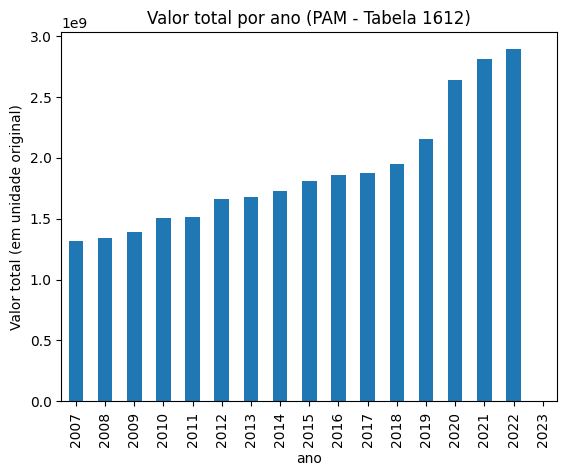

<Axes: title={'center': 'Top 10 produtos por valor total'}, xlabel='produto'>

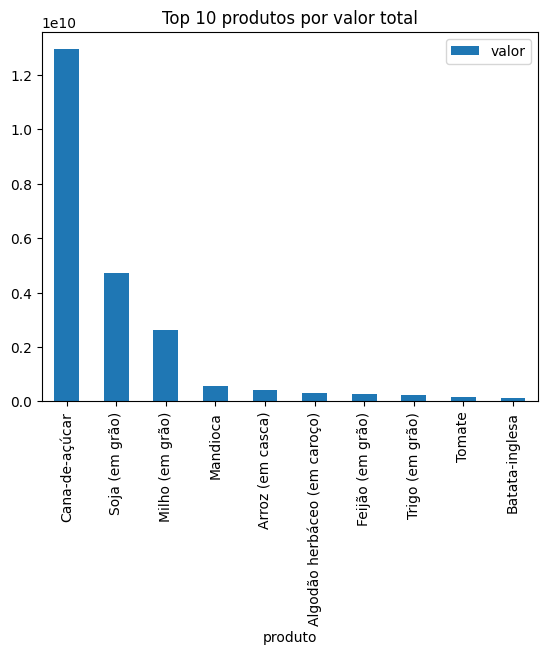

In [44]:
# Rename 'valor_raw' to 'valor' for consistency
long_df = long_df.rename(columns={"valor_raw": "valor"})
df_no_total = df_no_total.rename(columns={"valor_raw": "valor"})

# Ensure 'valor' column is numeric
long_df["valor"] = pd.to_numeric(long_df["valor"], errors="coerce")
df_no_total["valor"] = pd.to_numeric(df_no_total["valor"], errors="coerce")

# Drop rows with NaN values in 'valor' column
long_df = long_df.dropna(subset=["valor"])
df_no_total = df_no_total.dropna(subset=["valor"])

# Valor total por ano
yearly = long_df.groupby("ano")["valor"].sum().sort_index()
yearly.plot(kind="bar", title="Valor total por ano (PAM - Tabela 1612)")
plt.ylabel("Valor total (em unidade original)")
plt.show()

# Top 10 produtos
top_prod = (df_no_total
            .groupby('produto', as_index=False)['valor'].sum()
            .sort_values('valor', ascending=False)
            .head(10))
top_prod.plot(kind='bar', x='produto', y='valor', title='Top 10 produtos por valor total')


In [50]:
out_path = "tabela1612_clean.csv"
long_df.to_csv(out_path, index=False, encoding="utf-8")
print("✅ Arquivo limpo salvo como:", out_path)


✅ Arquivo limpo salvo como: tabela1612_clean.csv


In [ ]:
path = "/Users/carolina/Desktop/Ciencia_de_Dados/OPT004-TrabalhoFinal/tabela1612-3.csv"

# Leitura inicial para extrair o cabeçalho complexo
with open(path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# As linhas 4 e 5 (índices 3 e 4 em base 0) contêm as informações de cabeçalho
# A linha 4 tem os anos, a linha 5 tem os produtos

# Processar a linha de anos (linha 4 do CSV original, índice 3 em 'lines')
years_header_line = lines[3].strip()
years_reader = csv.reader(io.StringIO(years_header_line), delimiter=';', quotechar='"')
years_row_parsed = next(years_reader)

# Processar a linha de produtos (linha 5 do CSV original, índice 4 em 'lines')
products_header_line = lines[4].strip()
products_reader = csv.reader(io.StringIO(products_header_line), delimiter=';', quotechar='"')
products_row_parsed = next(products_reader)

# Criar os novos nomes de colunas
new_cols = []
current_year = ''

# A primeira coluna é sempre 'Unidade da Federação'
new_cols.append(products_row_parsed[0])

# Iterar sobre as colunas de anos e produtos para construir o cabeçalho
# O número de colunas deve ser o mesmo em years_row_parsed e products_row_parsed
# e deve corresponder ao número de colunas de dados.
# Vamos usar o comprimento de years_row_parsed como referência para o loop.
for i in range(1, len(years_row_parsed)):
    year_val = years_row_parsed[i].strip()
    product_val = products_row_parsed[i].strip()

    # Atualiza o ano atual se um valor de ano for encontrado
    if year_val:
        year_match = re.search(r'(\b20\d{2}\b)', year_val)
        if year_match:
            current_year = year_match.group(1)
    
    # Constrói o nome da coluna
    if product_val:
        # Se tiver produto, usa o ano atual e o produto
        new_cols.append(f"{current_year} - {product_val}")
    else:
        # Se não tiver produto, mas tiver ano, tenta usar o produto da coluna anterior
        # ou um placeholder se não for possível inferir
        if current_year and new_cols and " - " in new_cols[-1]:
            last_product = new_cols[-1].split(" - ")[1]
            new_cols.append(f"{current_year} - {last_product}")
        else:
            # Fallback para colunas sem produto ou ano claro
            new_cols.append(f"UNKNOWN_COL_{i}")

# Agora, ler o restante do CSV com pandas, pulando as linhas de cabeçalho já processadas
df_raw_data = pd.read_csv(path, sep=";", quotechar='"', skiprows=5, header=None, engine="python", on_bad_lines="skip")

# É crucial que len(new_cols) seja igual a df_raw_data.shape[1]
# Se houver um mismatch, vamos ajustar new_cols para ter o mesmo comprimento
if len(new_cols) != df_raw_data.shape[1]:
    print(f"AVISO: Mismatch de colunas. new_cols tem {len(new_cols)} elementos, enquanto df_raw_data tem {df_raw_data.shape[1]} elementos.")
    # Ajustar new_cols para ter o mesmo comprimento, truncando ou preenchendo com placeholders
    if len(new_cols) > df_raw_data.shape[1]:
        new_cols = new_cols[:df_raw_data.shape[1]]
    else:
        for j in range(len(new_cols), df_raw_data.shape[1]):
            new_cols.append(f"Placeholder_Col_{j}")

df_raw_data.columns = new_cols

print("Shape inicial dos dados:", df_raw_data.shape)
print(f"Length of new_cols after adjustment: {len(new_cols)}")

id_cols = ["Unidade da Federação"]
val_cols = [c for c in df_raw_data.columns if c not in id_cols and not c.startswith("UNKNOWN_PRODUCT") and not c.startswith("UNKNOWN_COL") and not c.startswith("Placeholder_Col")]

long_df = df_raw_data.melt(id_vars=id_cols, value_vars=val_cols, var_name="ano_produto", value_name="valor_raw")

long_df[["ano", "produto"]] = long_df["ano_produto"].str.extract(r'(\b20\d{2}\b)\s*-\s*(.*)')
long_df = long_df.drop(columns=["ano_produto"])

long_df["valor_raw"] = long_df["valor_raw"].replace("-", np.nan)
long_df["valor_raw"] = pd.to_numeric(long_df["valor_raw"], errors="coerce")
long_df = long_df.fillna(0)

long_df = long_df.rename(columns={"Unidade da Federação": "local", "valor_raw": "valor"})

uf_pattern = r"^[A-Za-zÀ-ú\s]+$"
long_df = long_df[long_df["local"].astype(str).str.match(uf_pattern, na=False)].copy()

df_no_total = long_df[~long_df["produto"].str.contains(r'(?i)^total')].copy()

print("Número de registros após limpeza:", df_no_total.shape[0])

long_df["ano"] = pd.to_numeric(long_df["ano"])
df_no_total["ano"] = pd.to_numeric(df_no_total["ano"])

# --- Feature Engineering ---
total_valor_uf_ano = df_no_total.groupby(["local", "ano"])["valor"].sum().reset_index()
total_valor_uf_ano.rename(columns={"valor": "valor_total_uf"}, inplace=True)

total_valor_nacional_ano = df_no_total.groupby("ano")["valor"].sum().reset_index()
total_valor_nacional_ano.rename(columns={"valor": "valor_total_nacional"}, inplace=True)

total_valor_uf_ano["valor_total_uf_prev_ano"] = total_valor_uf_ano.groupby("local")["valor_total_uf"].shift(1)
total_valor_uf_ano["crescimento_anual_uf"] = (total_valor_uf_ano["valor_total_uf"] - total_valor_uf_ano["valor_total_uf_prev_ano"]) / total_valor_uf_ano["valor_total_uf_prev_ano"]

total_valor_nacional_ano["valor_total_nacional_prev_ano"] = total_valor_nacional_ano.groupby("ano")["valor_total_nacional"].shift(1)
total_valor_nacional_ano["crescimento_anual_nacional"] = (total_valor_nacional_ano["valor_total_nacional"] - total_valor_nacional_ano["valor_total_nacional_prev_ano"]) / total_valor_nacional_ano["valor_total_nacional_prev_ano"]

df_merged = pd.merge(total_valor_uf_ano, total_valor_nacional_ano[["ano", "crescimento_anual_nacional"]], on="ano", how="left")

df_merged["crescimento_anual_uf"] = df_merged["crescimento_anual_uf"].replace([np.inf, -np.inf], np.nan).fillna(0)
df_merged["crescimento_anual_nacional"] = df_merged["crescimento_anual_nacional"].replace([np.inf, -np.inf], np.nan).fillna(0)
df_merged["crescimento_acima_media_nacional"] = (df_merged["crescimento_anual_uf"] > df_merged["crescimento_anual_nacional"]).astype(int)

df_final = pd.merge(df_no_total, df_merged[["local", "ano", "valor_total_uf", "crescimento_anual_uf", "crescimento_acima_media_nacional"]], on=["local", "ano"], how="left")

df_final["valor_produto_prev_ano"] = df_final.groupby(["local", "produto"])["valor"].shift(1)
df_final["participacao_produto_uf"] = df_final["valor"] / df_final["valor_total_uf"]
df_final["media_movel_3_anos"] = df_final.groupby(["local", "produto"])["valor"].transform(lambda x: x.rolling(3, min_periods=1).mean().shift(1))
df_final["valor_total_uf_lag1"] = df_final.groupby("local")["valor_total_uf"].shift(1)
df_final["crescimento_anual_uf_lag1"] = df_final.groupby("local")["crescimento_anual_uf"].shift(1)
df_final["local_encoded"] = df_final["local"].astype("category").cat.codes
df_final["produto_encoded"] = df_final["produto"].astype("category").cat.codes
df_final["interacao_produto_ano"] = df_final["produto_encoded"] * df_final["ano"]
df_final["diferenca_media_movel"] = df_final["valor"] - df_final["media_movel_3_anos"]

produtos_alto_valor = ["Soja (em grão)", "Milho (em grão)", "Cana-de-açúcar"]
df_final["is_produto_alto_valor"] = df_final["produto"].isin(produtos_alto_valor).astype(int)

df_final["valor_produto_prev_2anos"] = df_final.groupby(["local", "produto"])["valor"].shift(2)
df_final["crescimento_produto_anual"] = (df_final["valor"] - df_final["valor_produto_prev_ano"]) / df_final["valor_produto_prev_ano"]
df_final["valor_produto_prev_3anos"] = df_final.groupby(["local", "produto"])["valor"].shift(3)

df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.fillna(0, inplace=True)

df_modelagem = df_final.dropna().copy()

preditor_cols = [
    "ano", "valor_total_uf", "crescimento_anual_uf", "valor_produto_prev_ano",
    "participacao_produto_uf", "media_movel_3_anos", "valor_total_uf_lag1",
    "crescimento_anual_uf_lag1", "local_encoded", "produto_encoded",
    "interacao_produto_ano", "diferenca_media_movel", "is_produto_alto_valor",
    "valor_produto_prev_2anos", "crescimento_produto_anual", "valor_produto_prev_3anos"
]

existing_preditor_cols = [col for col in preditor_cols if col in df_modelagem.columns]

print(f"Número de preditores criados: {len(existing_preditor_cols)}")
print("Primeiras linhas do DataFrame com features:")
print(df_modelagem[existing_preditor_cols + ["crescimento_acima_media_nacional"]].head())

out_path_features = "tabela1612_features.csv"
df_modelagem.to_csv(out_path_features, index=False, encoding="utf-8")
print(f"Arquivo com features salvo como: {out_path_features}")

# --- Visualizações ---
yearly = long_df.groupby("ano")["valor"].sum().sort_index()
yearly.plot(kind="bar", title="Valor total por ano (PAM - Tabela 1612)")
plt.ylabel("Valor total (em unidade original)")
plt.savefig("valor_total_por_ano.png")
plt.close()

top_prod = (df_no_total
            .groupby("produto", as_index=False)["valor"].sum()
            .sort_values("valor", ascending=False)
            .head(10))
top_prod.plot(kind="bar", x="produto", y="valor", title="Top 10 produtos por valor total")
plt.savefig("top_10_produtos.png")
plt.close()

out_path_clean = "tabela1612_clean4.csv"
long_df.to_csv(out_path_clean, index=False, encoding="utf-8")
print(f"Arquivo limpo original salvo como: {out_path_clean}")


AVISO: Mismatch de colunas. new_cols tem 546 elementos, enquanto df_raw_data tem 579 elementos.
Shape inicial dos dados: (288, 579)
Length of new_cols after adjustment: 579
Número de registros após limpeza: 131472
Número de preditores criados: 16
Primeiras linhas do DataFrame com features:
    ano  valor_total_uf  crescimento_anual_uf  valor_produto_prev_ano  \
0  2007       2702464.0                   0.0                     0.0   
1  2007       1230089.0                   0.0                     0.0   
2  2007       1884614.0                   0.0                     0.0   
3  2007        493509.0                   0.0                     0.0   
4  2007      11038011.0                   0.0                     0.0   

   participacao_produto_uf  media_movel_3_anos  valor_total_uf_lag1  \
0                 0.000209                 0.0                  0.0   
1                 0.000204                 0.0                  0.0   
2                 0.003317                 0.0           